In [48]:
import pandas as pd
import numpy as np
import csv
from tqdm import trange

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [49]:
def read_frames_from_csv(filename):
    frames = []
    current_frame = []

    with open(filename, 'r', newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            if not row:  # Blank row signals new frame
                if current_frame:
                    frames.append(np.array(current_frame, dtype=float))
                    current_frame = []
            else:
                current_frame.append([float(x) for x in row])

        # Add the last frame if file didn't end with a blank line
        if current_frame:
            frames.append(np.array(current_frame, dtype=float))

    return frames

# Usage
distance_matrices = read_frames_from_csv('distance_matrices.csv')
clusteriness_matrices = read_frames_from_csv('clusteriness_matrices.csv')
acceleration_clusteriness_matrices = read_frames_from_csv('acceleration_clusteriness_matrices.csv')
asymetric_metric_matrices = read_frames_from_csv('asymetric_metric_matrices.csv')

In [50]:
def calculate_laplacian_matrix(matrix):
    """Using formula L = D - A to compute laplacian matrix"""
    
    # calculate (TODO in or out?) degrees
    degrees = matrix.sum(axis=1)

    # create degree matrix
    degree_matrix = np.diag(degrees)

    laplacian = degree_matrix - matrix

    return laplacian, degrees


In [51]:
def compute_algebraic_connectivity_and_connected_components(matrix, tol=1e-12):
    """compute laplaican matrix and its eigenvalues and its number of connected components"""

    n = matrix.shape[0]

    laplacian, degrees = calculate_laplacian_matrix(matrix)

    # Initialize D^{-1/2}
    D_inv_sqrt = np.zeros((n, n))
    for i, d in enumerate(degrees):
        if d > 0:
            D_inv_sqrt[i, i] = 1.0 / np.sqrt(d)
        else:
            D_inv_sqrt[i, i] = 0.0  # isolated node


    normalized_laplacian = np.eye(n) - D_inv_sqrt @ matrix @ D_inv_sqrt

    # No. of connected components is the rank of the kernel matrix.
    # the dimension of the kernel matrix is the dimension of the matrix - its rank
    laplacian_rank = np.linalg.matrix_rank(laplacian, tol)
    kernel_rank = n - laplacian_rank

    laplacian_eigenvalues_normed = np.linalg.eigvals(normalized_laplacian)
    eigenvalues_sorted = np.sort(laplacian_eigenvalues_normed)

    algebraic_connectivity = eigenvalues_sorted[1]

    return algebraic_connectivity, kernel_rank

In [52]:
# compute metrics for distance
distance_laplace_analysis = []

for matrix_index in trange(len(distance_matrices)):
    matrix = distance_matrices[matrix_index]
    algebraic_connectivity, kernel_rank = compute_algebraic_connectivity_and_connected_components(matrix)
    data = {'algebraic_connectivity': algebraic_connectivity, 'kernel_rank': kernel_rank}

    distance_laplace_analysis.append(data)


# compute metrics for clusteriness
clusteriness_laplace_analysis = []


for matrix_index in trange(len(clusteriness_matrices)):
    matrix = clusteriness_matrices[matrix_index]

    algebraic_connectivity, kernel_rank = compute_algebraic_connectivity_and_connected_components(matrix)
    data = {'algebraic_connectivity': algebraic_connectivity, 'kernel_rank': kernel_rank}

    clusteriness_laplace_analysis.append(data)


# compute metrics for acceleration clusteriness
acceleration_clusteriness_laplace_analysis = []

for matrix_index in trange(len(acceleration_clusteriness_matrices)):
    matrix = acceleration_clusteriness_matrices[matrix_index]

    algebraic_connectivity, kernel_rank = compute_algebraic_connectivity_and_connected_components(matrix)
    data = {'algebraic_connectivity': algebraic_connectivity, 'kernel_rank': kernel_rank}

    acceleration_clusteriness_laplace_analysis.append(data)


# compute metrics for acceleration clusteriness
asymetric_metric_laplace_analysis = []

for matrix_index in trange(len(asymetric_metric_matrices)):
    matrix = asymetric_metric_matrices[matrix_index]

    algebraic_connectivity, kernel_rank = compute_algebraic_connectivity_and_connected_components(matrix)
    data = {'algebraic_connectivity': algebraic_connectivity, 'kernel_rank': kernel_rank}

    asymetric_metric_laplace_analysis.append(data)





100%|██████████| 820/820 [00:00<00:00, 2069.40it/s]


c:\Users\luigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\luigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


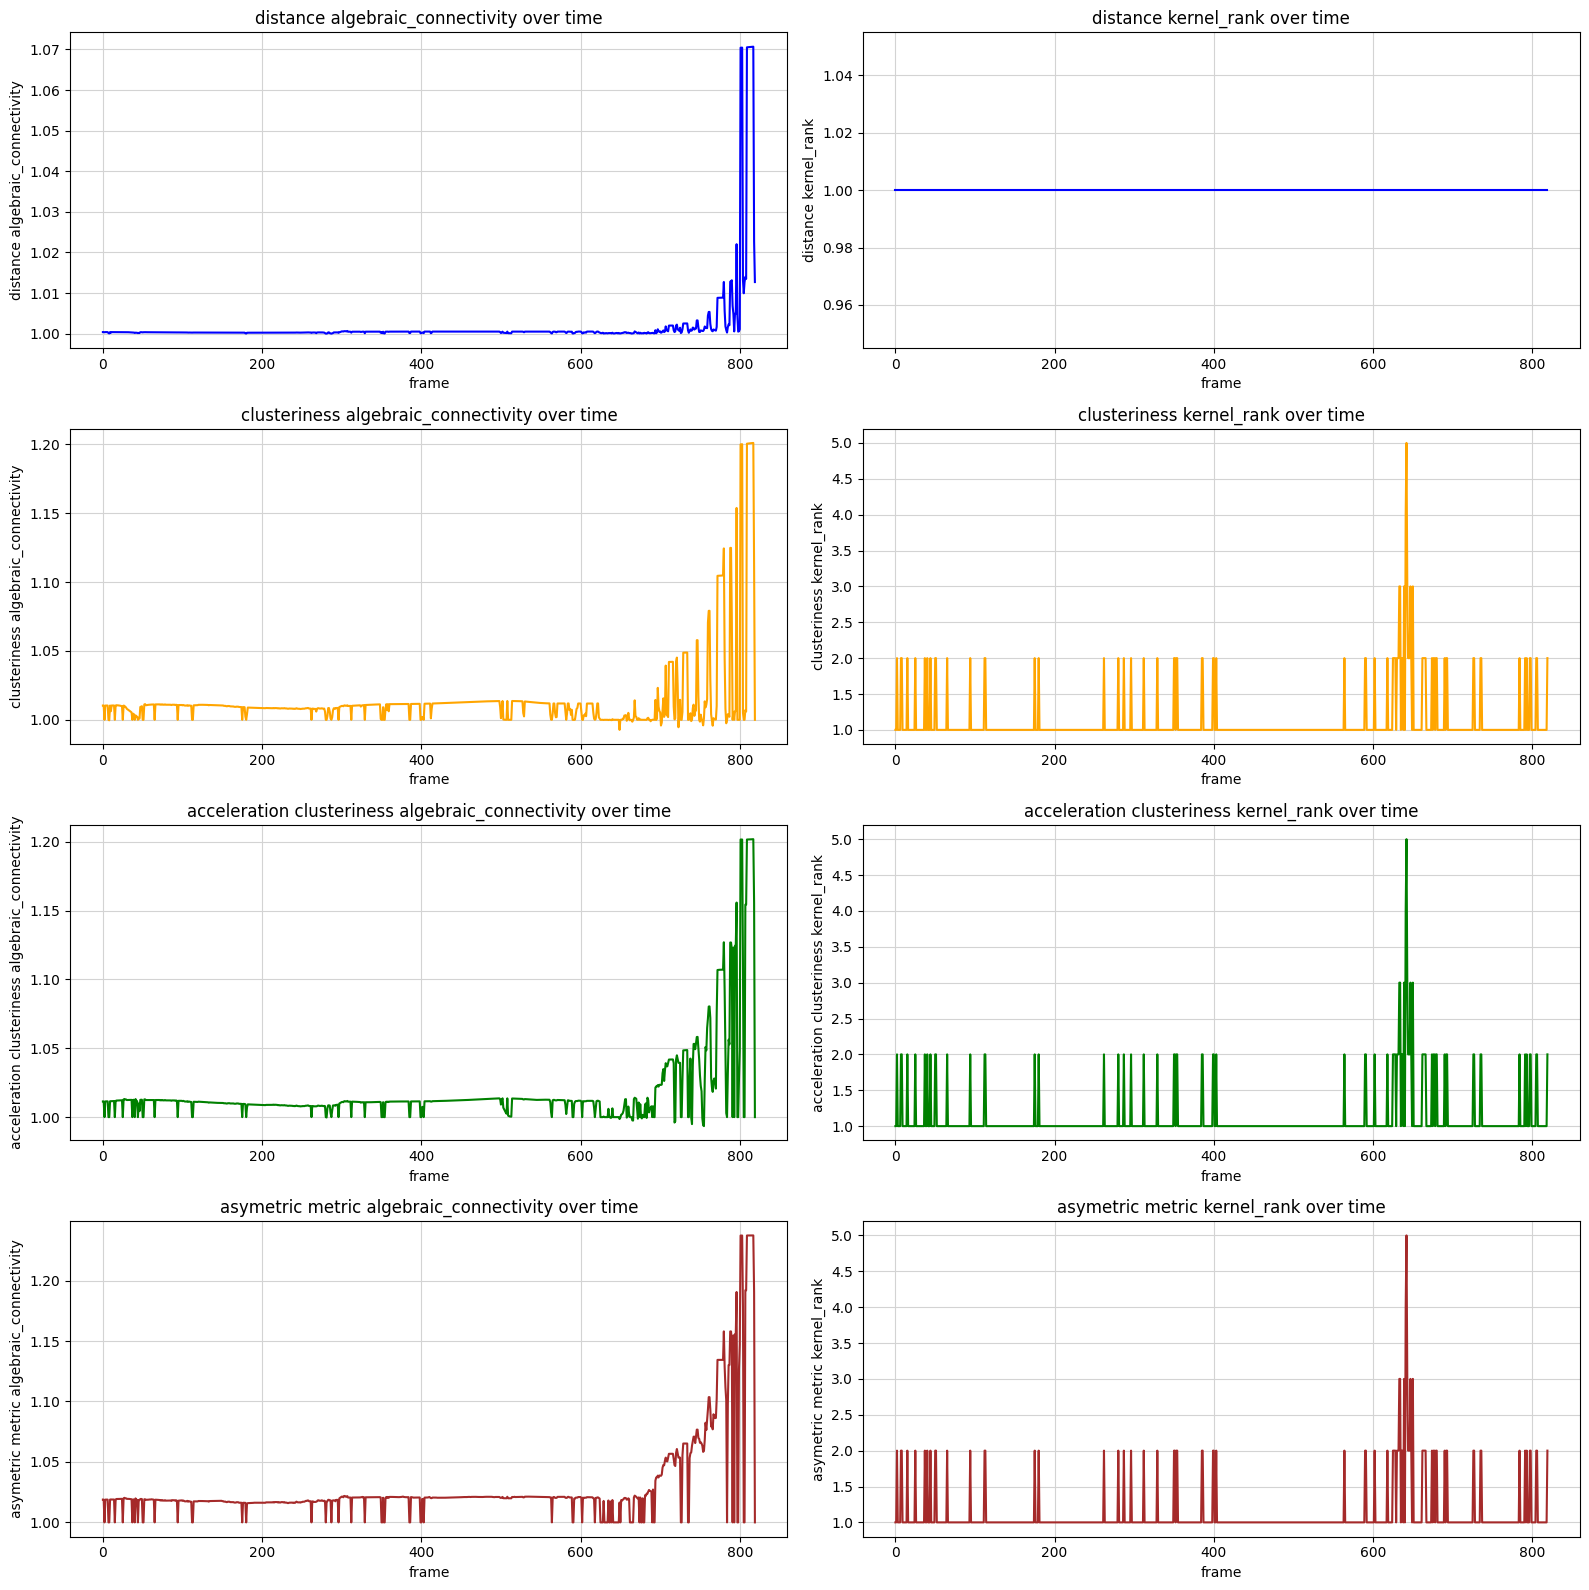

In [53]:
fig, ax = plt.subplots(4, 2, figsize=(16, 16))

frames = [i for i in range(len(distance_matrices))]
data_points_to_plot = [
    distance_laplace_analysis,
    clusteriness_laplace_analysis,
    acceleration_clusteriness_laplace_analysis,
    asymetric_metric_laplace_analysis,
    ]
colors = ['blue', 'orange', 'green', 'brown']
data_names = ["distance", "clusteriness", "acceleration clusteriness", "asymetric metric"]
data_points = ["algebraic_connectivity", "kernel_rank"]

for i in range(4):
    for j in range(2):
        plot_axis = ax[i][j]

        sns.lineplot(
            x=frames,
            y=[data[data_points[j]] for data in data_points_to_plot[i]],
            ax=plot_axis,
            color=colors[i],
        )

        plot_axis.set_title(f"""{data_names[i]} {data_points[j]} over time""")
        plot_axis.set_xlabel(f"""frame""")
        plot_axis.set_ylabel(f"""{data_names[i]} {data_points[j]}""")
        plot_axis.grid(color='lightgrey')

    plt.tight_layout()